# Imports

In [1]:
import os
import glob
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import pickle

from tensorflow.keras import Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from astropy.io import fits

from config import *
from objects import COORDS
from utils import (download_data,
                   sample_fits,
                   data_augmentation,
                   normalize,
                   fits_processing,
                   fits2images,
                   save_images)


np.random.seed(SEED)
%load_ext tensorboard

# Downloading Data

In [2]:
download_data(COORDS,DATA_DIR)

establishing connection to splus ...
Login: welberth
Password: ········
downloading splus data ...


100%|███████████████████████████████████████████| 25/25 [00:31<00:00,  1.24s/it]


downloading legacy survey data ...


100%|███████████████████████████████████████████| 25/25 [01:12<00:00,  2.90s/it]

Done!


In [2]:
fits2images(DATA_DIR,IMAGES_DIR)

saving training images ...


100%|█████████████████████████████████████████| 250/250 [00:17<00:00, 14.48it/s]


saving validation images ...


100%|███████████████████████████████████████████| 25/25 [00:01<00:00, 14.12it/s]


# GAN Architecture

## Generator

In [84]:
def residual_block(x):
    """
    Residual block
    """
    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    # Add res and x
    res = Add()([res, x])
    return res


def build_generator():
    """
    Create a generator network using the hyperparameter values defined below
    :return:
    """
    residual_blocks = 16
    momentum = 0.8
    input_shape = (128, 128, 3)

    # Input Layer of the generator network
    input_layer = Input(shape=input_shape)

    # Add the pre-residual block
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)
    gen15 = Conv2D(filters=64, kernel_size=15, strides=1, padding='same', activation='relu')(gen1)
    # Add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)

    # Add the post-residual block
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)

    # Take the sum of the output from the pre-residual block(gen1) and the post-residual block(gen2)
    gen3 = Add()([gen2, gen15])

    # Add an upsampling block
    gen4 = UpSampling2D(size=2, interpolation='bilinear')(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)

    # Output convolution layer
    gen5 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen4)
    output = Activation('tanh')(gen5)

    return Model(inputs=[input_layer], outputs=[output], name='generator')



## Discriminator

In [3]:
def build_discriminator():
    """
    Create a discriminator network using the hyperparameter values defined below
    :return:
    """
    leakyrelu_alpha = 0.2
    momentum = 0.8
    input_shape = (256, 256, 3)

    input_layer = Input(shape=input_shape)

    # Add the first convolution block
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    # Add the 2nd convolution block
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    # Add the third convolution block
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    # Add the fourth convolution block
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    # Add the fifth convolution block
    dis5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    # Add the sixth convolution block
    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    # Add the seventh convolution block
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    # Add the eight convolution block
    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)

    # Add a dense layer
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)

    # Last dense layer - for classification
    output = Dense(units=1, activation='sigmoid')(dis9)
    
    discriminator = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    discriminator.compile(loss='mse', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

    return discriminator

## VGG - Imagenet

In [4]:
def build_vgg():
    """
    Build VGG network to extract image features
    """

    # Load a pre-trained VGG19 model trained on 'Imagenet' dataset
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=(256,256,3))
    vgg.trainable = False
    
    model_vgg = Model(inputs=vgg.inputs, outputs=vgg.layers[9].output)
    model_vgg.compile(loss='mse', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

    return model_vgg


## Adversarial Model

In [5]:
# define the combined generator and discriminator model, for updating the generator
def build_adversarial_model(generator,discriminator,vgg):
    
    # Inputs
    input_high_resolution = Input(shape=(256,256,3))
    input_low_resolution = Input(shape=(128,128,3))
    
    generated_high_resolution_images = generator(input_low_resolution)
    features = vgg(generated_high_resolution_images)
    
    discriminator.trainable = False
    probs = discriminator(generated_high_resolution_images)
    
    # Create and compile an adversarial model
    adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
    adversarial_model.compile(loss=['binary_crossentropy', 'mse'],
                              loss_weights=[1e-3, 1], 
                              optimizer=Adam(0.0002, 0.5))
    
    return adversarial_model

# Train

## Data Preprocessing

In [6]:
def get_data(data_dir:str = DATA_DIR+"train/",
             train_size:float = TRAIN_SIZE,
             augmentation_factor:int = AUGMENTATION_FACTOR)->tuple:
    
    # load fits
    train_splus_fits, train_legacy_fits,_ = sample_fits(data_dir,TRAIN_SIZE)
    
    # asinh shrink and normalize
    train_splus_images,train_legacy_images = fits_processing(train_splus_fits),fits_processing(train_legacy_fits)
    
    # perform data augmentation
    augmented_data = (data_augmentation(train_splus_images, augmentation_factor=augmentation_factor),
                      data_augmentation(train_legacy_images, augmentation_factor=augmentation_factor))
    
    return augmented_data

## Training Function

In [7]:
def train_GAN(generator,
              discriminator,
              vgg,
              adversarial_model,
              data, 
              epochs,
              batch_size,
              summary_writer):
    
    batches_per_epoch = int(data[0].shape[0]/batch_size)
    step = 0
    for epoch in range(epochs):
        print(f"Epoch:{epoch}")
        for i in range(batches_per_epoch):
    
            """
            Train the discriminator network
            """
            # get a batch of images
            splus_images = data[0][i * batch_size:(i + 1) * batch_size]
            legacy_images = data[1][i * batch_size:(i + 1) * batch_size]
        
            # Generate high-resolution images from low-resolution images
            generated_images = generator.predict(splus_images)
        
            # Generate batch of real and fake labels
            SR_labels = np.ones((BATCH_SIZE, 16, 16, 1))
            LR_labels = np.zeros((BATCH_SIZE, 16, 16, 1))
        
            # Train the discriminator network on LR and SR images
            d_loss_real = discriminator.train_on_batch(legacy_images, SR_labels)
            d_loss_fake = discriminator.train_on_batch(generated_images, LR_labels)
        
            # Calculate total discriminator loss
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            print("d_loss:", d_loss)
        
            """
            Train the generator network
            """
        
            # Extract feature maps for real high-resolution images
            image_features = vgg.predict(legacy_images)
        
            # Train the generator network
            g_loss = adversarial_model.train_on_batch([splus_images, legacy_images],
                                             [SR_labels, image_features])
        
            print("g_loss:", g_loss)
        
            # Write the losses to Tensorboard
            with summary_writer.as_default():
                tf.summary.scalar('generator_loss', g_loss[0], step=step)
                tf.summary.scalar('disciminator_loss', d_loss[0], step=step)
                summary_writer.flush()
                
            step +=1
        
        # Sample and save validation images after every 100 epochs
        if epoch % 100 == 0:
            splus_fits, legacy_fits,_ = sample_fits(DATA_DIR+"validation/",3)
            
            # Asinh Shrink and Normalize images
            low_resolution_images = fits_processing(splus_fits)
            high_resolution_images = fits_processing(legacy_fits)
    
            generated_images = generator.predict_on_batch(low_resolution_images)
            generated_images = normalize(generated_images)
    
            for index, img in enumerate(generated_images):
                save_images(low_resolution_images[index], high_resolution_images[index], img,path="results/img_{}_{}".format(epoch, index))
        
        # Save model checkpoint after 1000 epochs
        if epoch % 1000 == 0:
            generator.save_weights("generator.h5")
            discriminator.save_weights("discriminator.h5")
            
    # Save final models
    generator.save_weights("generator.h5")
    discriminator.save_weights("discriminator.h5")

## Training

In [43]:
rm -r logs/

In [44]:
data = get_data()

In [95]:
with open('validation_data.pkl','rb') as f:
                 data1,data2 = pickle.load(f)

In [134]:
np.random.choice(range(25), 3, replace = False)

array([12, 20,  1])

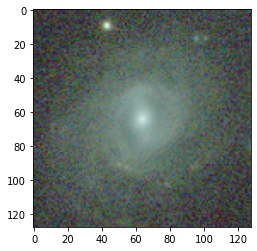

In [133]:
plt.imshow(data1[9])

In [94]:
with open('validation_data.pkl','wb') as f:
     pickle.dump(validation_data, f)

In [23]:
vgg = build_vgg()
discriminator = build_discriminator()
generator = build_generator()
adversarial_model = build_adversarial_model(generator,discriminator,vgg)

try:
    with open('data.pkl','rb') as f:
         data = pickle.load(f)
except:
    print("data.pkl not found, trying to preprocess data from raw fits ...")
    data = get_data()

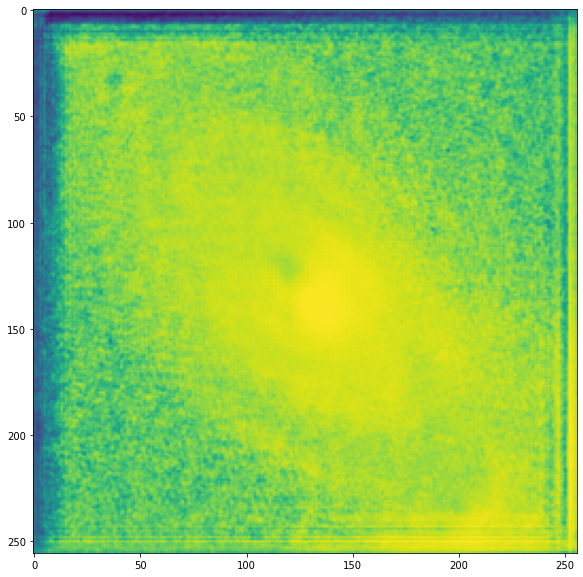

In [129]:
r_img = np.expand_dims(data[0][5],axis=0)
out = generator(r_img)[0]
vmin_val = np.percentile(out, 1)
vmax_val = np.percentile(out, 99.5)
fix,ax = plt.subplots(figsize=(10,10))
ax.imshow(out[:,:,0], vmin=vmin_val, vmax=vmax_val)

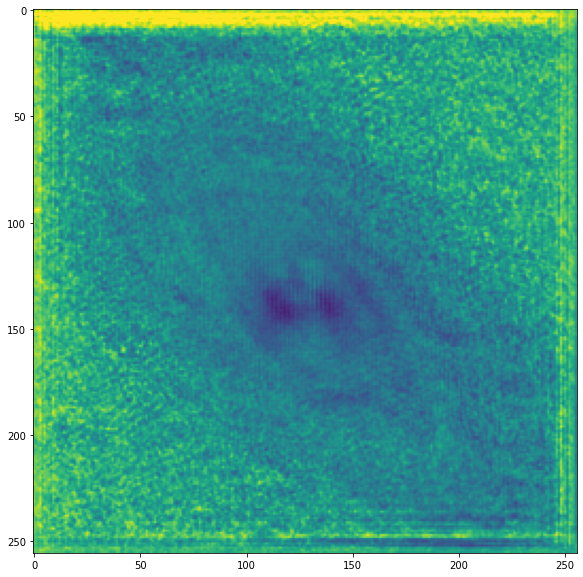

In [130]:
r_img = np.expand_dims(data[0][5],axis=0)
out = generator1(r_img)[0]
vmin_val = np.percentile(out, 1)
vmax_val = np.percentile(out, 99.5)
fix,ax = plt.subplots(figsize=(10,10))
ax.imshow(out[:,:,1], vmin=vmin_val, vmax=vmax_val)

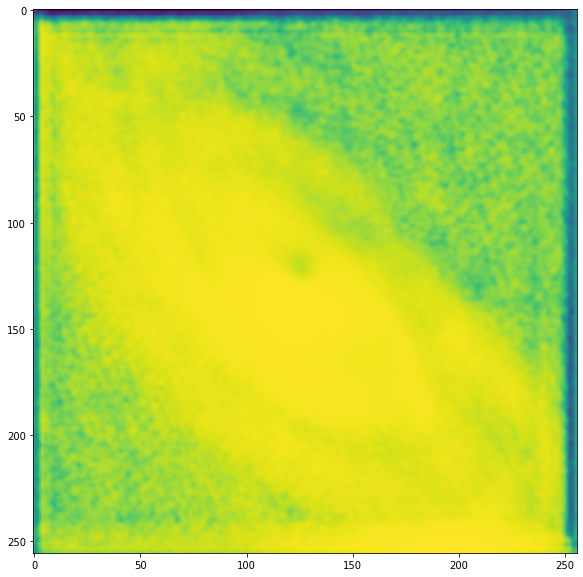

In [128]:
r_img = np.expand_dims(data[0][5],axis=0)
out = generator3(r_img)[0]
vmin_val = np.percentile(out, 1)
vmax_val = np.percentile(out, 99.5)
fix,ax = plt.subplots(figsize=(10,10))
ax.imshow(out[:,:,2])

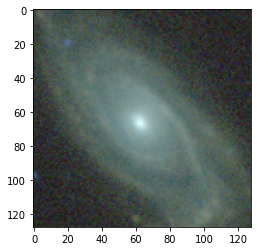

In [115]:
plt.imshow(r_img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


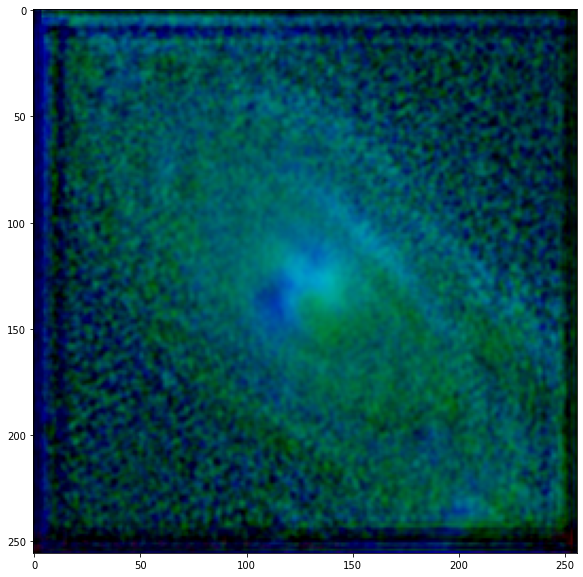

In [125]:
r_img = np.expand_dims(data[0][5],axis=0)
out = generator4(r_img)[0]
vmin_val = np.percentile(out, 1)
vmax_val = np.percentile(out, 99.5)
fix,ax = plt.subplots(figsize=(10,10))
ax.imshow(out, vmin=vmin_val, vmax=vmax_val)

In [11]:
%tensorboard --logdir {dir_writer}

In [12]:
train_GAN(generator,
          discriminator,
          vgg,
          adversarial_model,
          data, 
          epochs = 30,
          batch_size = BATCH_SIZE,
          summary_writer = summary_writer)

Epoch:0


2021-08-15 20:31:38.771111: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


d_loss: [0.35696186 0.40996094]
g_loss: [103.07905578613281, 0.6302959322929382, 103.07841491699219]
d_loss: [0.29841691 0.45761719]
g_loss: [56.7684211730957, 0.7570024728775024, 56.767662048339844]
d_loss: [0.21541672 0.66210938]
g_loss: [23.55597686767578, 0.7912254333496094, 23.555185317993164]
d_loss: [0.19600723 0.63984376]
g_loss: [14.27336311340332, 1.879446029663086, 14.271482467651367]
d_loss: [0.07605557 0.93535158]
g_loss: [15.041994094848633, 3.776254177093506, 15.038217544555664]
d_loss: [0.02406871 0.98964843]
g_loss: [15.123529434204102, 5.466404438018799, 15.118062019348145]
d_loss: [0.01207479 1.        ]
g_loss: [15.074897766113281, 6.48482608795166, 15.068412780761719]
d_loss: [0.00474694 1.        ]
g_loss: [14.75987434387207, 8.487457275390625, 14.751385688781738]
Epoch:1
d_loss: [0.00406523 1.        ]
g_loss: [14.476346015930176, 11.729751586914062, 14.464614868164062]
d_loss: [0.00380422 1.        ]
g_loss: [14.045880317687988, 14.635702133178711, 14.0312442779

KeyboardInterrupt: 